In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Unzip DataSet
local_zip = '/content/Teeth DataSet.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/Teeth DataSet')


zip_ref.close()
print("Dataset extracted successfully!")

BadZipFile: File is not a zip file

In [ ]:
base_dir = '/content/Teeth DataSet/Teeth_Dataset'

train_dir = os.path.join(base_dir, 'Training')
val_dir   = os.path.join(base_dir, 'Validation')
test_dir  = os.path.join(base_dir, 'Testing')


In [ ]:
train_classes = os.listdir(train_dir)
print(f'TRAIN CLASSES: {train_classes}')

val_classes = os.listdir(val_dir)
print(f'VAL CLASSES: {val_classes}')

test_classes = os.listdir(test_dir)
print(f'TEST CLASSES: {test_classes}')

TRAIN CLASSES: ['OLP', 'MC', 'CaS', 'OT', 'CoS', 'Gum', 'OC']
VAL CLASSES: ['OLP', 'MC', 'CaS', 'OT', 'CoS', 'Gum', 'OC']
TEST CLASSES: ['OLP', 'MC', 'CaS', 'OT', 'CoS', 'Gum', 'OC']


In [ ]:
def count_images(directory):
    classes = [c for c in os.listdir(directory) if os.path.isdir(os.path.join(directory, c))]
    counts = {}
    for c in classes:
        class_dir = os.path.join(directory, c)
        num_images = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        counts[c] = num_images
    return counts

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)
print(f'TRAIN COUNTS: {train_counts}')
print(f'VAL COUNTS: {val_counts}')
print(f'TEST COUNTS: {test_counts}')

TRAIN COUNTS: {'OLP': 540, 'MC': 540, 'CaS': 480, 'OT': 393, 'CoS': 450, 'Gum': 360, 'OC': 324}
VAL COUNTS: {'OLP': 180, 'MC': 180, 'CaS': 160, 'OT': 131, 'CoS': 149, 'Gum': 120, 'OC': 108}
TEST COUNTS: {'OLP': 180, 'MC': 180, 'CaS': 160, 'OT': 131, 'CoS': 149, 'Gum': 120, 'OC': 108}


In [ ]:
print("Total train images:", sum(train_counts.values()))
print("Total val images:", sum(val_counts.values()))
print("Total test images:", sum(test_counts.values()))


Total train images: 3087
Total val images: 1028
Total test images: 1028


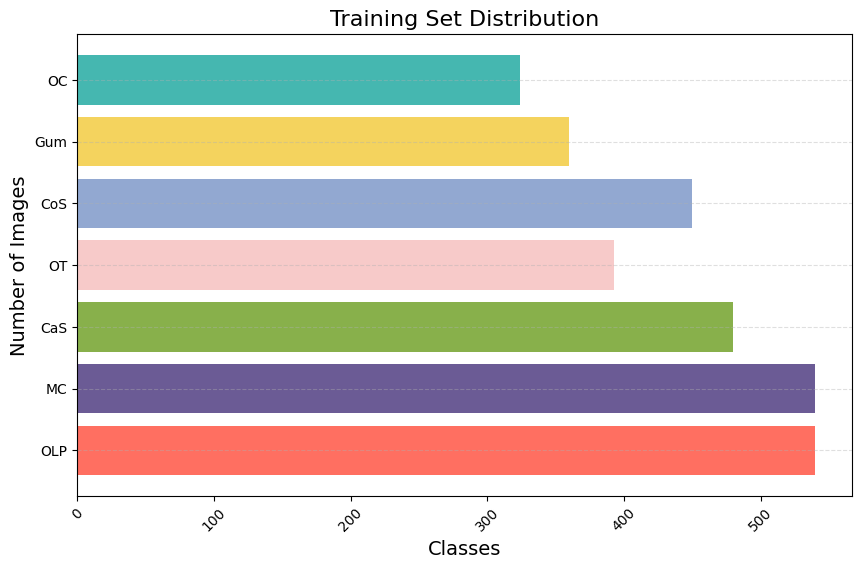

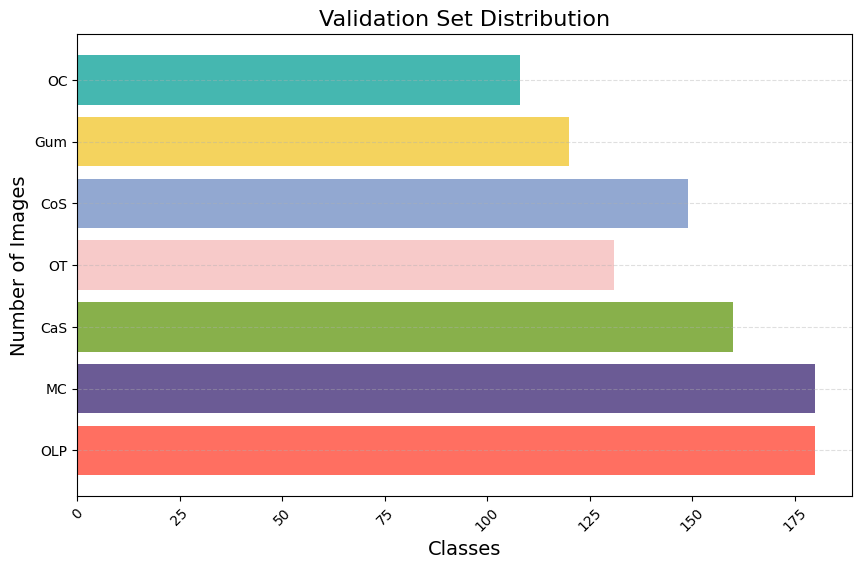

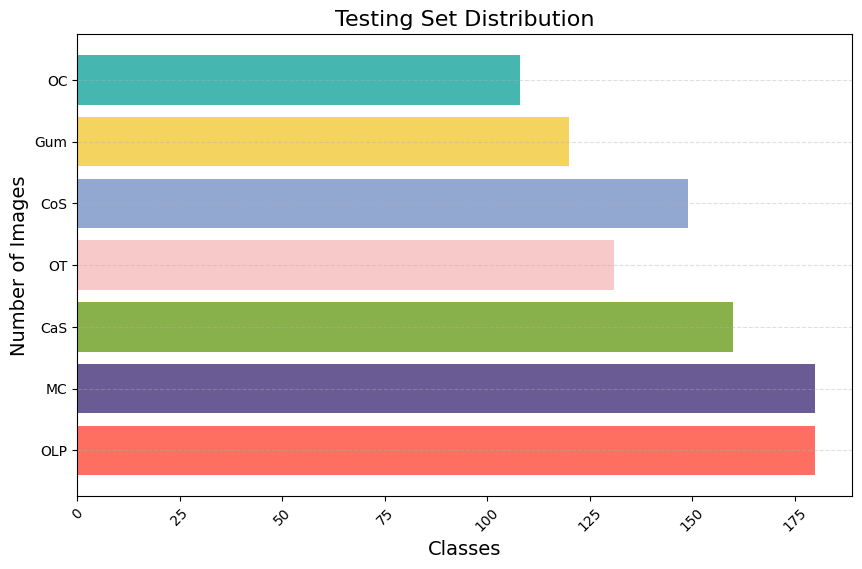

In [ ]:
def plot_distribution(counts, title, colors):
    classes = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(10,6))
    plt.barh(classes, values, color=colors)
    plt.title(title, fontsize=16)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#F4D35E', '#45B7B0']

plot_distribution(train_counts, 'Training Set Distribution', colors)
plot_distribution(val_counts, 'Validation Set Distribution', colors)
plot_distribution(test_counts, 'Testing Set Distribution', colors)


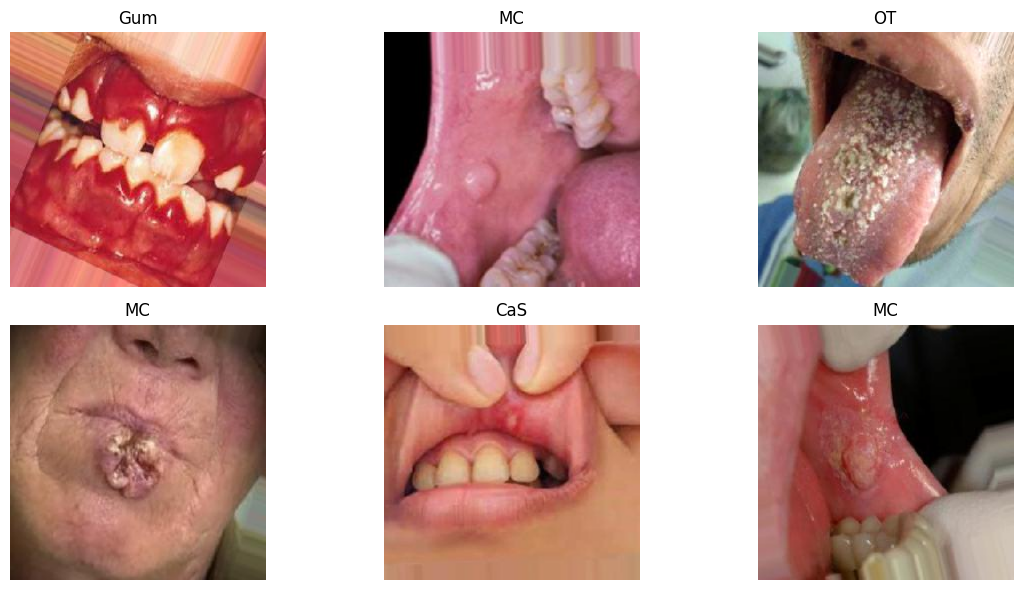

In [ ]:
num_samples = 6
image_size = (224, 224)

classes = [c for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))]

plt.figure(figsize=(12,6))

for i in range(num_samples):
    # Pick random class
    sample_class = random.choice(classes)
    sample_dir = os.path.join(train_dir, sample_class)

    # Pick random image
    sample_image = random.choice(os.listdir(sample_dir))
    sample_path = os.path.join(sample_dir, sample_image)

    img = load_img(sample_path, target_size=image_size)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(sample_class)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
       class_mode='categorical',
       shuffle=True
)


validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
        )

test_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
        )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


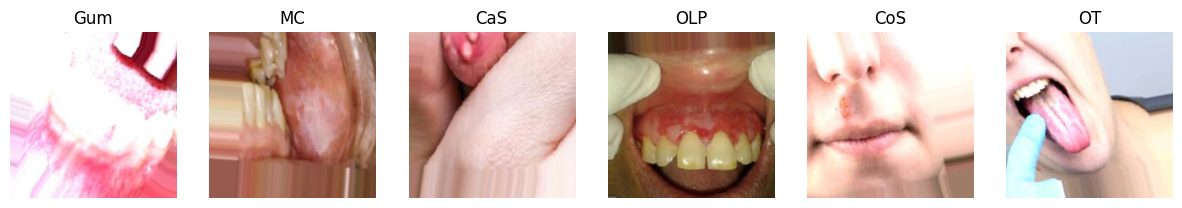

In [ ]:

classes = [c for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))]
selected_classes = random.sample(classes, 6)   # 6 different diseases

plt.figure(figsize=(15,3))

for i, cls in enumerate(selected_classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img_path = os.path.join(train_dir, cls, img_name)

    img = load_img(img_path, target_size=image_size)
    x = img_to_array(img).astype('float32')

    augmented = train_datagen.random_transform(x)

    plt.subplot(1,6,i+1)
    plt.imshow(augmented.astype('uint8'))
    plt.axis('off')
    plt.title(cls)

plt.show()





1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━

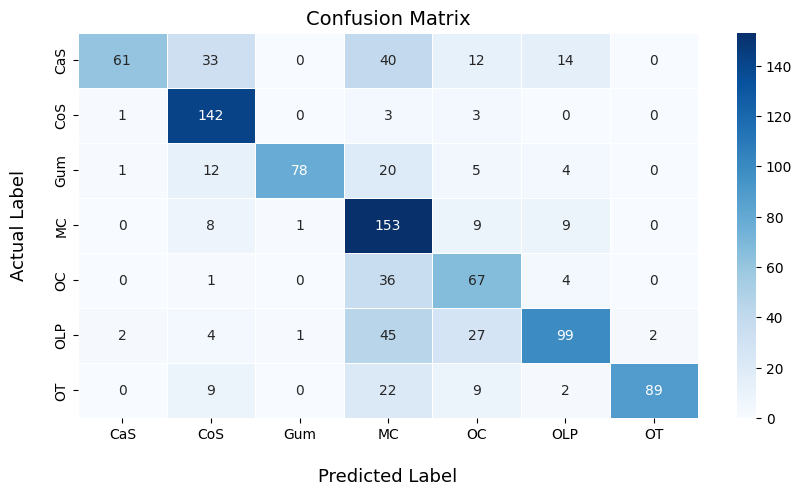

In [ ]:
labels = list(test_generator.class_indices.keys())
num_classes = len(labels)

actual_labels = []
predicted_labels = []

for i in range(len(test_generator)):
    images, batch_labels = test_generator[i]
    batch_preds = model.predict(images)
    batch_preds = np.argmax(batch_preds, axis=1)

    batch_labels = np.argmax(batch_labels, axis=1)

    actual_labels.extend(batch_labels)
    predicted_labels.extend(batch_preds)

actual_labels = np.array(actual_labels, dtype=int)
predicted_labels = np.array(predicted_labels, dtype=int)

cm = confusion_matrix(actual_labels, predicted_labels)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, linewidths=0.5)
plt.xlabel('\nPredicted Label', fontsize=13)
plt.ylabel('Actual Label\n', fontsize=13)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

In [ ]:
report = classification_report(actual_labels, predicted_labels, target_names=labels)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         CaS       0.94      0.38      0.54       160
         CoS       0.68      0.95      0.79       149
         Gum       0.97      0.65      0.78       120
          MC       0.48      0.85      0.61       180
          OC       0.51      0.62      0.56       108
         OLP       0.75      0.55      0.63       180
          OT       0.98      0.68      0.80       131

    accuracy                           0.67      1028
   macro avg       0.76      0.67      0.67      1028
weighted avg       0.75      0.67      0.67      1028

